<center>
<h1 style="font-family:verdana">
 💻 🧑 Classificació d'intencions 🧑 💻


<p> 🎯 <b>Objectiu</b>: en aquesta pràctica aprendrem a detectar la intenció de l'usuari a partir d'interaccions reals amb un xatbot. En el context de xatbots, la classificació d'intencions ajuda a entendre quina acció o resposta hauria de prendre el sistema en funció de la consulta de l'usuari.  


<p> ✨ <b>Contingut</b>: en primer lloc, farem servir una base de dades amb oracions d'interaccions en espanyol etiquetades com 19 intencions diferents. En segon lloc, realitzarem el preprocessament de les dades, és a dir, transformarem les dades perquè tinguen un format adequat per a ser introduïdes al model. I finalment, dissenyarem i entrenarem el model de classificació per detectar automàticament la intenció de les oracions.</p>  


<p> ✏ <b>Exercicis</b>: en cada secció anireu trobant exercicis que haureu d'anar resolent. </p>



---

<h2> Índex </h2>

1. [Inspecció del conjunt de dades](#section-one)
  * [Exercici 1](#ex-one)
2. [Preprocessament de dades](#section-two)
  * [Exercici 2](#ex-two)
  * [Exercici 3](#ex-three)
3. [Disseny del model i entrenament](#section-three)
  * [Exercici 4](#ex-four)
  * [Exercici 5](#ex-five)
4. [Lliurable](#section-four)
---

In [36]:
import random
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D, Dropout, Conv1D, GlobalAveragePooling1D, LayerNormalization #Remove
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('wordnet')
import matplotlib.pyplot as plt

# import seaborn as sns
# from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/manukali/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/manukali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t"
!tar -zxf nlu_ATIS_data.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t
To: /home/manukali/TVD_P2/nlu_ATIS_data.tar.gz
  0%|                                                | 0.00/122k [00:00<?, ?B/s]Downloading...
From: https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t
To: /home/manukali/TVD_P2/nlu_ATIS_data.tar.gz
100%|████████████████████████████████████████| 122k/122k [00:00<00:00, 1.48MB/s]
100%|████████████████████████████████████████| 122k/122k [00:00<00:00, 1.48MB/s]


<h1><a name="section-one"> 1. Inspecció del conjunt de dades </a></h1>

A la carpeta `data` tenim els diferents fitxers CSV que utilitzarem per a aquesta pràctica.

En primer lloc, llegirem les dades dels fitxers CSV amb `pandas`.

In [38]:
train_data = pd.read_csv('./data/train.csv', header=None)
val_data = train_data.tail(900)
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)
test_data = pd.read_csv('./data/test.csv', header=None)

print('Training size:', len(train_data))
print('Validation dataset size:', len(val_data))
print('Test dataset size:', len(test_data))

Training size: 4078
Validation dataset size: 900
Test dataset size: 893


Per a aquesta primera part de la pràctica ens centrarem en la primera columna dels arxius que correspon amb les **oracions** en anglès introduïdes per l'usuari. I en la tercera columna que correspon amb la **intenció** de cada oració, és a dir, cada oració tindrà una etiqueta.

Podeu executar la cel·la següent tantes vegades com vulgueu per veure instàncies d'aquest conjunt de dades.


In [39]:
random_number = random.randint(0, len(train_data)-1)

train_sentences = list(train_data[0])
train_labels = list(s.replace('"', '') for s in train_data[2])
train_labels = list(s.replace(' ', '') for s in train_labels)

print('Sentence: ', train_sentences[random_number])
print('Intent: ', train_labels[random_number])

Sentence:  what are the flights from atlanta to dallas
Intent:  flight


In [40]:
test_sentences = list(test_data[0])

A continuació analitzarem quantes etiquetes diferents hi ha al dataset i quines són.

In [41]:
num_labels = 0
for label in set(train_labels):
  print(f'Label {num_labels}:', label.split('.')[-1])
  num_labels += 1

print(f'\nThere are a total of {num_labels} intent labels')

Label 0: distance
Label 1: ground_fare
Label 2: restriction
Label 3: flight_no
Label 4: abbreviation
Label 5: airport
Label 6: city
Label 7: airfare
Label 8: capacity
Label 9: aircraft+flight+flight_no
Label 10: quantity
Label 11: aircraft
Label 12: meal
Label 13: airfare+flight_time
Label 14: ground_service+ground_fare
Label 15: flight_time
Label 16: flight+airfare
Label 17: airline
Label 18: ground_service
Label 19: flight
Label 20: airline+flight_no
Label 21: cheapest

There are a total of 22 intent labels


<h1><a name="section-two"> 2. Preprocessament de dades </a></h1>

En primer lloc, haurem de tokenitzar les oracions. Això consisteix a convertir el text en representacions numèriques, ja que els models esperen unitats discretes.

En aquesta pràctica farem servir una tokenització senzilla, simplement dividirem les oracions en paraules i crearem un vocabulari basat en les paraules úniques de les dades d'entrenament. Cada paraula (token) tindrà assignat un ID únic.

Vegem com queda el vocabulari.

In [42]:
num_words=500
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(train_sentences)

vocab = tokenizer.word_index #diccionario con todas las palabras del corpus y su índice ordenado por frecuencia.
print(vocab)
print(len(vocab))

{'to': 1, 'from': 2, 'flights': 3, 'the': 4, 'on': 5, 'what': 6, 'me': 7, 'flight': 8, 'boston': 9, 'show': 10, 'san': 11, 'i': 12, 'denver': 13, 'a': 14, 'francisco': 15, 'in': 16, 'and': 17, 'atlanta': 18, 'pittsburgh': 19, 'is': 20, 'dallas': 21, 'baltimore': 22, 'all': 23, 'philadelphia': 24, 'like': 25, 'are': 26, 'list': 27, 'airlines': 28, 'of': 29, 'between': 30, 'that': 31, 'washington': 32, 'leaving': 33, 'please': 34, 'pm': 35, 'morning': 36, 'would': 37, 'fly': 38, 'for': 39, 'fare': 40, 'first': 41, 'wednesday': 42, 'after': 43, 'there': 44, 'oakland': 45, "'d": 46, 'ground': 47, 'you': 48, 'does': 49, 'trip': 50, 'transportation': 51, 'class': 52, 'arriving': 53, 'cheapest': 54, 'need': 55, 'city': 56, 'round': 57, 'with': 58, 'before': 59, 'which': 60, 'available': 61, 'have': 62, 'give': 63, 'at': 64, 'fares': 65, 'american': 66, 'afternoon': 67, 'one': 68, 'want': 69, 'how': 70, 'way': 71, 'new': 72, 'dc': 73, 'nonstop': 74, 'arrive': 75, 'earliest': 76, 'york': 77, 'g

---

 <h1><a name="ex-one"><center> ✏ Exercici 1 ✏</a></h1>

En aquest primer exercici us demanem que donat el vocabulari anterior convertiu la llista d'oracions de la partició d'entrenament, és a dir, `train_sentenes` en seqüències d'IDs.

Podeu trobar la documentació [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).

In [43]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]


Si ho heu fet correctament hauríeu d'obtenir això:

```
print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]
```



---
A continuació haurem d'aconseguir que totes les seqüències tinguen una longitud fixa. Per a fer això primer fixarem la longitud segons la longitud màxima trobada a les seqüències del conjunt d'entrenament. I a continuació omplirem (*pad*) les seqüències que tinguen una longitud menor.


In [44]:
max_sequence_length = max(map(len, train_sequences))


train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)
print('Padded sequence: ', train_pad_sequences[0])
print(len(train_pad_sequences[0]))

Padded sequence:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  12  69   1  38   2   9  64 415  84
  17  75  16  13  64 493  16   4  36]
45


---

 <h1><a name="ex-two"><center> ✏ Exercici 2 ✏</a></h1>

Com l'ordre de les paraules sí que importa als models que utilitzarem en aquesta pràctica, és aconsellable que el *padding* estiga al final i no al principi. Busqueu [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) com fer perquè el codi anterior afegisca els zeros al final i no al principi de la seqüència.

In [45]:
#TODO
 
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')

print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [ 12  69   1  38   2   9  64 415  84  17  75  16  13  64 493  16   4  36
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


Si ho heu fet correctament hauríeu d'obtenir això:

```
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [ 12  69   1  38   2   9  64 415  84  17  75  16  13  64 493  16   4  36
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
```


---

A continuació convertirem les classes d'intencions categòriques (*capacity*, *ground_service*, *flight*, etc.) en el que anomenem one-hot vector encoding. Aquesta tècnica s'utilitza per representar les dades categòriques com a vectors binaris. On cada vector representa una classe específica i l'element corresponent a la classe es posa a 1 i la resta d'elements es mantenen a 0.

Imaginem que tenim tres classes: *capacity*, *ground_service*, *flight*. Podríem codificar aquestes classes amb un vector únic de la forma següent:


```
   capacity -> [1, 0, 0]
   ground_service -> [0, 1, 0]
   flight -> [0, 0, 1]
```

Per aconseguir això primer codificarem les classes d'intenció en etiquetes numèriques.

In [46]:
label_encoder = LabelEncoder()
train_numerical_labels = label_encoder.fit_transform(train_labels)

print(f'Original labels: {train_labels}\n')
print(f'Encoded labels: {train_numerical_labels} \n')

Original labels: ['flight', 'flight', 'flight_time', 'airfare', 'airfare', 'flight', 'aircraft', 'flight', 'flight', 'ground_service', 'flight', 'flight', 'airport', 'flight', 'flight', 'airfare', 'ground_service', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'airline', 'flight', 'ground_service', 'flight', 'airfare', 'flight', 'flight', 'flight', 'flight', 'airfare', 'airline', 'flight', 'flight', 'flight', 'distance', 'flight', 'airline', 'airline', 'flight', 'airline', 'ground_service', 'abbreviation', 'flight', 'flight', 'flight_time', 'flight', 'flight', 'ground_fare', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'ground_service', 'airline', 'flight', 'flight', 'airport', 'flight', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'flight', 'flight', 'fli

I a continuació convertim les etiquetes a vectors one-hot.

In [47]:
num_classes = len(np.unique(train_numerical_labels))
train_encoded_labels = to_categorical(train_numerical_labels, num_classes)

print('Example: \n')
print(f'Original label: {train_labels[0]}\n')
print(f'Numerical label: {train_numerical_labels[0]}\n')
print(f'One-hot: {train_encoded_labels[0]}\n')

Example: 

Original label: flight

Numerical label: 12

One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



---

 <h1><a name="ex-three"><center> ✏ Exercici 3 ✏</a></h1>

Amb la partició de validació i test haurem de realitzar els mateixos passos. Per tant, en aquest exercici us demanem que obtingueu `val_pad_sequences`, `val_encoded_labels`, `test_pad_sequences` i `test_encoded_labels`.

In [48]:
#TODO
val_pad_sequences = pad_sequences(tokenizer.texts_to_sequences(list(val_data[0])), maxlen=max_sequence_length, padding='post')
test_pad_sequences =  pad_sequences(tokenizer.texts_to_sequences(list(test_data[0])), maxlen=max_sequence_length, padding='post')


In [49]:
val_labels = list(val_data[2])
test_labels = list(test_data[2])

# limpiar las etiquetas de val y test
val_labels = [lbl.strip().replace('"', '').replace("'", '') for lbl in val_labels]
test_labels = [lbl.strip().replace('"', '').replace("'", '') for lbl in test_labels]

def remove_values_and_indices(input_list, values_to_remove, other_list):
    indices_to_remove = [idx for idx, item in enumerate(input_list) if item in values_to_remove]
    cleaned_list = [item for item in input_list if item not in values_to_remove]
    cleaned_other_list = [item for idx, item in enumerate(other_list) if idx not in indices_to_remove]
    return cleaned_list, np.array(cleaned_other_list)

values_to_remove = ['day_name','airfare+flight','flight+airline','flight_no+airline']
val_labels, val_pad_sequences = remove_values_and_indices(val_labels, values_to_remove, val_pad_sequences)
test_labels, test_pad_sequences = remove_values_and_indices(test_labels, values_to_remove, test_pad_sequences)


In [50]:
#primero pasamos las labels a numericas
val_numerical_labels = label_encoder.transform(val_labels)
test_numerical_labels = label_encoder.transform(test_labels)

val_encoded_labels = to_categorical(val_numerical_labels, num_classes)
test_encoded_labels = to_categorical(test_numerical_labels, num_classes)

---

<h1><a name="section-three"> 3. Disseny del model i entrenament </a></h1>

En primer lloc, anem a comprovar si hi ha GPUs disponibles. A continuació si hi ha GPUs disponibles el codi assegurarà que *TensorFlow* només assigne memòria GPU quan siga necessari.

In [51]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("GPU is not available. The model will be trained on CPU.")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

GPU is not available. The model will be trained on CPU.


---

 <h1><a name="ex-four"><center> ✏ Exercici 4 ✏</a></h1>

En aquest exercici haureu de dissenyar l'arquitectura del model. El nostre model tindrà quatre capes:

1. La primera capa serà un **embedding**. Aquesta capa permetrà convertir les dades de text d'entrada, en vectors densos amb una mida fixa (*embedding_dim*). Aquesta representació més compacta permetrà per una part capturar la informació semàntica del text d'entrada, permetent així generalitzar millor i comprendre les relacions entre les paraules. I, per una altra banda, reduir la complexitat computacional, accelerant així el temps d'entrenament i inferència. En resum, aquesta capa assignarà a cada índex de cada paraula un vector dens de mida *embedding_dim*.

2. La segona capa serà un **pooling** layer. L'entrada d'aquesta capa serà un tensor 3D (*batch_size*, *sequence_length*, *embedding_dim*). Aquesta capa es centrarà a capturar la informació més important de la seqüència d'entrada, és a dir, prendrà el valor màxim de la seqüència, donant lloc a un tensor 2D (batch_size, embedding_dim).

3. La tercera capa serà una capa **densa**. És a dir, una capa completament connectada (*fully-connected*): cada neurona d'aquesta capa estarà connectada a totes les neurones de la capa anterior. La funció d'activació que utilitzarem serà una ReLU. Aquesta funció introdueix una no-linealitat al model permetent així aprendre relacions complexes en les dades.

4. L'última capa també serà una capa **densa**. En aquest cas la funció d'activació haurà de ser la funció Softmax. Aquesta funció es fa servir per a convertir els valors de la capa anterior (*logits*) en probabilitats normalitzades. El valor de cada element de sortida representarà la probabilitat que l'entrada pertanya a una classe específica.


📢  Les capes que haureu de fer servir les podreu trobar [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/layers).





In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping


if not os.path.exists('./models/basic_model.keras'):
    # Paràmetres
    vocab_size = len(vocab)       # 893 paraules
    embedding_dim = 300           # mida del vector d'embedding
    max_sequence_length = 45      # longitud fixa de les seqüències després del padding
    num_classes = len(label_encoder.classes_)  # nombre de classes

    # Definim el model
    modelo_basico = Sequential([
        # Capa Embedding
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),

        # Global Max Pooling
        GlobalMaxPooling1D(),

        # Capa Dense amb ReLU
        Dense(128, activation='relu'),

        # Capa Dense amb Softmax (sortida)
        Dense(num_classes, activation='softmax')
    ])

    # Compilar el model
    modelo_basico.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(
        monitor='val_loss',     # se fija en la pérdida de validación
        patience=5,             # espera 3 epochs sin mejora antes de parar
        restore_best_weights=True
    )

    # Entrenament
    history = modelo_basico.fit(
        train_pad_sequences, train_encoded_labels,
        validation_data=(val_pad_sequences, val_encoded_labels),
        epochs=30,
        batch_size=32,
        callbacks=[early_stop]
    )
    #Guardamos el modelo para poder usarlo posteriormente en caso de que lo necesitemos.
    modelo_basico.save('./models/basic_model.keras')
else:
    modelo_basico = tf.keras.models.load_model('./models/basic_model.keras')

Podeu veure a continuació les oracions que el model ha classificat incorrectament.

In [53]:
probs = modelo_basico.predict(test_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)

for i in range(0, len(predicted_labels)):
  if test_labels[i] != predicted_labels[i]:
    print('Sentence: ', test_sentences[i])
    print('Original label: ', test_labels[i])
    print('Predicted label: ', predicted_labels[i])
    print()


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Sentence:  show flight and prices kansas city to chicago on next wednesday arriving in chicago by 7 pm
Original label:  flight+airfare
Predicted label:  flight

Sentence:  i need a flight from tampa to milwaukee
Original label:  meal
Predicted label:  flight

Sentence:  i need a flight from milwaukee to seattle
Original label:  meal
Predicted label:  flight

Sentence:  please find a flight from orlando to kansas city
Original label:  airport
Predicted label:  flight

Sentence:  which flights are available from san jose to nashville leaving in the morning on april twenty three
Original label:  airline
Predicted label:  flight

Sentence:  what is the latest flight from baltimore to oakland that serves dinner
Original label:  city
Predicted label:  flight

Sentence:  i need to get from cincinnati to denver on june sixth by 6 pm
Original label:  ground_fare
Predicted label:  airfare

Sentence:  what 's the ground transportation in denver
Original lab

---

 <h1><a name="ex-five"><center> ✏ Exercici 5 ✏ </a></h1>

Modifiqueu els següents paràmetres del model anterior i analitzeu com afecten a la seva *accuracy*:

 1. **Preprocessament.** Modifiqueu el Tokenizer per canviar la mida del vostre vocabulari i afegiu nous passos de preprocessament. Alguns possibles canvis són canviar la mida del vocabulari, treure la capitalització o fer servir *lemmatització* o *stemming*.


In [60]:
# Preprocesamiento avanzado: lematización y descapitalización
def preprocess(num_words, train_sentences, val_data, test_data):
    lemmatizer = WordNetLemmatizer()

    def preprocess_sentence(sentences):
        processed = []
        for sentence in sentences:
            words = nltk.word_tokenize(sentence.lower())  # descapitalización y tokenización
            lemmatized = [lemmatizer.lemmatize(word) for word in words]
            processed.append(' '.join(lemmatized))
        return processed

    # Aplica el preprocesamiento a los datos de entrenamiento, validación y test
    train_sentences_lemmatized = preprocess_sentence(train_sentences)
    val_sentences_lemmatized = preprocess_sentence(list(val_data[0]))
    test_sentences_lemmatized = preprocess_sentence(list(test_data[0]))

    # Tokenizer con el mismo num_words (puedes cambiarlo para comparar)
    tokenizer_lemmatized = Tokenizer(num_words)
    tokenizer_lemmatized.fit_on_texts(train_sentences_lemmatized)

    # Secuencias
    train_sequences_lemmatized = tokenizer_lemmatized.texts_to_sequences(train_sentences_lemmatized)
    val_sequences_lemmatized = tokenizer_lemmatized.texts_to_sequences(val_sentences_lemmatized)
    test_sequences_lemmatized = tokenizer_lemmatized.texts_to_sequences(test_sentences_lemmatized)

    # Padding
    max_sequence_length_lemmatized = max(map(len, train_sequences_lemmatized))
    train_pad_sequences_lemmatized = pad_sequences(train_sequences_lemmatized, maxlen=max_sequence_length_lemmatized, padding='post')
    val_pad_sequences_lemmatized = pad_sequences(val_sequences_lemmatized, maxlen=max_sequence_length_lemmatized, padding='post')
    test_pad_sequences_lemmatized = pad_sequences(test_sequences_lemmatized, maxlen=max_sequence_length_lemmatized, padding='post')

    # Las etiquetas se procesan igual que antes
    val_labels_lemmatized = [lbl.strip().replace('"', '').replace("'", '') for lbl in list(val_data[2])]
    test_labels_lemmatized = [lbl.strip().replace('"', '').replace("'", '') for lbl in list(test_data[2])]

    label_encoder_lemmatized = LabelEncoder()
    train_numerical_labels_lemmatized = label_encoder_lemmatized.fit_transform(train_labels)  # Usamos las etiquetas originales de entrenamiento
    train_encoded_labels_lemmatized = to_categorical(train_numerical_labels_lemmatized, num_classes)

    values_to_remove = ['day_name','airfare+flight','flight+airline','flight_no+airline']
    def remove_values_and_indices(input_list, values_to_remove, other_list):
        indices_to_remove = [idx for idx, item in enumerate(input_list) if item in values_to_remove]
        cleaned_list = [item for item in input_list if item not in values_to_remove]
        cleaned_other_list = [item for idx, item in enumerate(other_list) if idx not in indices_to_remove]
        return cleaned_list, np.array(cleaned_other_list)

    val_labels_lemmatized, val_pad_sequences_lemmatized = remove_values_and_indices(val_labels_lemmatized, values_to_remove, val_pad_sequences_lemmatized)
    test_labels_lemmatized, test_pad_sequences_lemmatized = remove_values_and_indices(test_labels_lemmatized, values_to_remove, test_pad_sequences_lemmatized)

    val_numerical_labels_lemmatized = label_encoder.transform(val_labels_lemmatized)
    test_numerical_labels_lemmatized = label_encoder.transform(test_labels_lemmatized)

    val_encoded_labels_lemmatized = to_categorical(val_numerical_labels_lemmatized, num_classes)
    test_encoded_labels_lemmatized = to_categorical(test_numerical_labels_lemmatized, num_classes)

    return train_pad_sequences_lemmatized, train_encoded_labels_lemmatized, val_pad_sequences_lemmatized, val_encoded_labels_lemmatized, test_pad_sequences_lemmatized, test_encoded_labels_lemmatized

In [61]:
import os

if not os.path.exists('./models/model_preprocessed.keras'):
    train_pad_sequences_lemmatized, train_encoded_labels_lemmatized, val_pad_sequences_lemmatized, val_encoded_labels_lemmatized, test_pad_sequences_lemmatized, test_encoded_labels_lemmatized = preprocess(500, train_sentences=train_sentences, val_data=val_data, test_data= test_data)
    # Paràmetres
    vocab_size = len(vocab)       # 893 paraules
    embedding_dim = 300           # mida del vector d'embedding
    max_sequence_length = 45      # longitud fixa de les seqüències després del padding
    num_classes = len(label_encoder.classes_)  # nombre de classes

    # Definim el model
    modelo_preprocesado = Sequential([
        # Capa Embedding
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),

        # Global Max Pooling
        GlobalMaxPooling1D(),

        # Capa Dense amb ReLU
        Dense(128, activation='relu'),

        # Capa Dense amb Softmax (sortida)
        Dense(num_classes, activation='softmax')
    ])

    # Compilar el model
    modelo_preprocesado.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(
        monitor='val_loss',     # se fija en la pérdida de validación
        patience=5,             # espera 3 epochs sin mejora antes de parar
        restore_best_weights=True
    )

    # Entrenament
    history = modelo_preprocesado.fit(
        train_pad_sequences_lemmatized, train_encoded_labels_lemmatized,
        validation_data=(val_pad_sequences_lemmatized, val_encoded_labels_lemmatized),
        epochs=30,
        batch_size=32,
        callbacks=[early_stop]
    )
    modelo_preprocesado.save('./models/model_preprocessed.keras')
else:
    modelo_preprocesado = tf.keras.models.load_model('./models/model_preprocessed.keras')

Epoch 1/30


/home/manukali/TVD_P2/TVD_P2_environment/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7464 - loss: 1.1241 - val_accuracy: 0.8222 - val_loss: 0.7722
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8757 - loss: 0.5314 - val_accuracy: 0.8889 - val_loss: 0.4517
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9127 - loss: 0.3173 - val_accuracy: 0.9200 - val_loss: 0.3264
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9436 - loss: 0.2060 - val_accuracy: 0.9333 - val_loss: 0.2594
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9657 - loss: 0.1409 - val_accuracy: 0.9378 - val_loss: 0.2223
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9796 - loss: 0.0957 - val_accuracy: 0.9489 - val_loss: 0.1932
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9863 - loss: 0.0698 - val_accuracy: 0.9578 - val_loss: 0.1749
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9899 - loss: 0.0537 - val_accuracy: 0.9544 - val_

In [69]:
# Evaluación en el conjunto de test
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
def evaluacion(model, test_labels, test_sequences):
    # Predicciones en test
    test_probs = model.predict(test_sequences)
    test_pred_labels = np.argmax(test_probs, axis=1)
    test_true_labels = np.argmax(test_labels, axis=1)
    # Accuracy
    test_accuracy = accuracy_score(test_true_labels, test_pred_labels)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Classification report
    all_labels = np.arange(len(label_encoder.classes_))
    print(classification_report(
        test_true_labels, test_pred_labels,
        labels=all_labels,
        target_names=label_encoder.classes_,
        zero_division=0
    ))

#no hacemos matriz de confusión porque las clases están demasiado desbalanceadas por la clase Flight


In [70]:
evaluacion(modelo_basico, test_labels=test_encoded_labels, test_sequences=test_pad_sequences)
evaluacion(modelo_preprocesado, test_labels=test_encoded_labels_lemmatized, test_sequences=test_pad_sequences_lemmatized)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Accuracy: 0.9279
                            precision    recall  f1-score   support

              abbreviation       1.00      1.00      1.00        33
                  aircraft       0.80      0.89      0.84         9
 aircraft+flight+flight_no       0.00      0.00      0.00         0
                   airfare       0.91      0.83      0.87        48
       airfare+flight_time       0.00      0.00      0.00         0
                   airline       0.92      0.92      0.92        38
         airline+flight_no       0.00      0.00      0.00         0
                   airport       0.85      0.61      0.71        18
                  capacity       0.95      0.90      0.93        21
                  cheapest       0.00      0.00      0.00         0
                      city       0.00      0.00      0.00         6
                  distance       1.00      0.90      0.95        10
                    flight       0.93      0.99      

Primero probamos con el mismo tamaño de vocabulario pero mejorando el preprocesamiento del conjunto de entrenamiento. A pesar de ello, los resultados son muy similares a los obtenidos anteriormente.

Ahora jugaremos con la medida del vocabulario

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


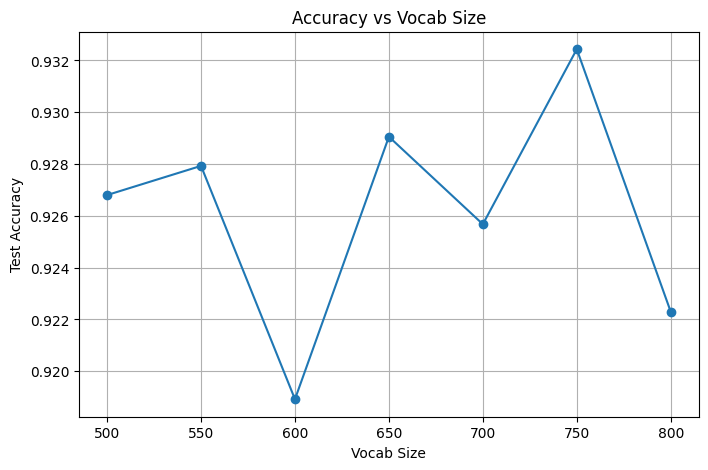

In [76]:
# Parámetros fijos
embedding_dim = 300
max_sequence_length = 45
num_classes = len(label_encoder.classes_)
batch_size = 32
epochs = 30
accuracies = list()
best_accuracy = 0
best_model = None
best_vocab_size = None

from keras.models import clone_model

vocab_sizes = list(range(500, 801, 50))
for vocab_size in vocab_sizes:
    # Tokenizer y secuencias para cada vocab_size
    train_pad_sequences_lemmatized, train_encoded_labels_lemmatized, val_pad_sequences_lemmatized, val_encoded_labels_lemmatized, test_pad_sequences_lemmatized, test_encoded_labels_lemmatized = preprocess(500, train_sentences=train_sentences, val_data=val_data, test_data= test_data)
    # Definim el model
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_pad_sequences_lemmatized, train_encoded_labels_lemmatized,
        validation_data=(val_pad_sequences_lemmatized, val_encoded_labels_lemmatized),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    test_probs = model.predict(test_pad_sequences_lemmatized)
    test_pred_labels = np.argmax(test_probs, axis=1)
    test_true_labels = np.argmax(test_encoded_labels_lemmatized, axis=1)
    test_accuracy = accuracy_score(test_true_labels, test_pred_labels)
    accuracies.append(test_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = clone_model(model)
        best_model.set_weights(model.get_weights())
        best_vocab_size = vocab_size

# Guardar el mejor modelo
best_model.save(f'./models/best_model_vocab_{best_vocab_size}.keras')

# Plot accuracy vs vocab_size
plt.figure(figsize=(8,5))
plt.plot(list(range(500,801,50)), accuracies, marker='o')
plt.xlabel('Vocab Size')
plt.ylabel('Test Accuracy')
plt.title('Accuracy vs Vocab Size')
plt.grid(True)
plt.show()

In [77]:
modelo_vocab_optimo = tf.keras.models.load_model(f'./models/best_model_vocab_{best_vocab_size}.keras')
evaluacion(modelo_vocab_optimo, test_labels=test_encoded_labels_lemmatized, test_sequences=test_pad_sequences_lemmatized)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Accuracy: 0.9324
                            precision    recall  f1-score   support

              abbreviation       1.00      1.00      1.00        33
                  aircraft       0.60      1.00      0.75         9
 aircraft+flight+flight_no       0.00      0.00      0.00         0
                   airfare       0.93      0.90      0.91        48
       airfare+flight_time       0.00      0.00      0.00         0
                   airline       0.92      0.87      0.89        38
         airline+flight_no       0.00      0.00      0.00         0
                   airport       1.00      0.78      0.88        18
                  capacity       1.00      0.76      0.86        21
                  cheapest       0.00      0.00      0.00         0
                      city       0.00      0.00      0.00         6
                  distance       1.00      0.90      0.95        10
                    flight       0.94      0.98      0


 2. **Mida dels Embeddings.** Proveu diferents mides d'*Embeddings* i observeu com canvia l'*accuracy* del model. Heu d'explicar les vostres conclusions.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


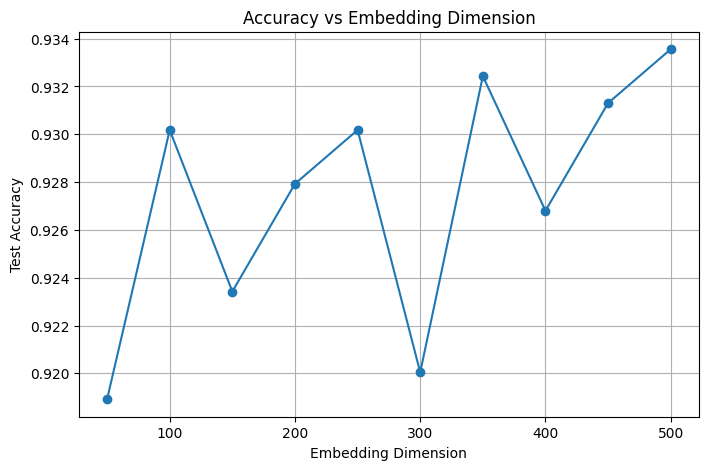

In [89]:
# Parámetros fijos
embedding_dims = list(range(50, 501, 50))
max_sequence_length = 45
num_classes = len(label_encoder.classes_)
batch_size = 32
epochs = 30
accuracies = list()
best_accuracy = 0
best_model = None
best_embedding_dim = None

from keras.models import clone_model

vocab_size = 750
for embedding_dim in embedding_dims:    
    train_pad_sequences_lemmatized, train_encoded_labels_lemmatized, val_pad_sequences_lemmatized, val_encoded_labels_lemmatized, test_pad_sequences_lemmatized, test_encoded_labels_lemmatized = preprocess(500, train_sentences=train_sentences, val_data=val_data, test_data= test_data)
    # Definim el model
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_pad_sequences_lemmatized, train_encoded_labels_lemmatized,
        validation_data=(val_pad_sequences_lemmatized, val_encoded_labels_lemmatized),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    test_probs = model.predict(test_pad_sequences_lemmatized)
    test_pred_labels = np.argmax(test_probs, axis=1)
    test_true_labels = np.argmax(test_encoded_labels_lemmatized, axis=1)
    test_accuracy = accuracy_score(test_true_labels, test_pred_labels)
    accuracies.append(test_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = clone_model(model)
        best_model.set_weights(model.get_weights())
        best_embedding_dim = embedding_dim

# Guardar el mejor modelo
best_model.save(f'./models/best_model_embedding{best_embedding_dim}.keras')

# Plot accuracy vs vocab_size
plt.figure(figsize=(8,5))
plt.plot(list(range(50, 501, 50)), accuracies, marker='o')
plt.xlabel('Embedding Dimension')
plt.ylabel('Test Accuracy')
plt.title('Accuracy vs Embedding Dimension')
plt.grid(True)
plt.show()

In [90]:
modelo_embedding_optimo = tf.keras.models.load_model(f'./models/best_model_embedding{best_embedding_dim}.keras')
evaluacion(modelo_embedding_optimo, test_labels=test_encoded_labels_lemmatized, test_sequences=test_pad_sequences_lemmatized)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test Accuracy: 0.9336
                            precision    recall  f1-score   support

              abbreviation       1.00      1.00      1.00        33
                  aircraft       0.57      0.89      0.70         9
 aircraft+flight+flight_no       0.00      0.00      0.00         0
                   airfare       0.91      0.88      0.89        48
       airfare+flight_time       0.00      0.00      0.00         0
                   airline       0.92      0.92      0.92        38
         airline+flight_no       0.00      0.00      0.00         0
                   airport       1.00      0.89      0.94        18
                  capacity       0.94      0.76      0.84        21
                  cheapest       0.00      0.00      0.00         0
                      city       0.00      0.00      0.00         6
                  distance       1.00      0.90      0.95        10
                    flight       0.94      0.98      


 3. **Xarxes Convolucionals.** Afegiu capes convolucionals al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació a l'hora d'escollir-los. Recordeu, que també podeu provar diferents configuracions de *pooling*.



 4. **Xarxes Recurrents.**  Afegiu capes recurrents al vostre model (LSTM, GRU). Expliqueu amb detall els valors que heu provat i la vostra motivació.

 5. **Regularització.** Quan proveu configuracions amb més paràmetres veureu que el model comença a tenir *overfitting* molt prompte durant l'entrenament. Afegiu *Dropout* al vostre model. Heu d'explicar la vostra decisió de valors i de posició dins de la xarxa.

 6. **Balancejat de les classes.** Si analitzeu el dataset, veureu que la freqüència de les classes està molt desbalancejada. Keras us permet afegir un pes per a cada classe a l'hora de calcular la loss (Mireu el paràmetre "class_weigth" a la documentació https://keras.io/api/models/model_training_apis/). Calculeu un pes per a cada classe i afegiu-lo al mètode fit del vostre model.

 ---


<h1><a name="section-four"> 4. Lliurable </a></h1>

Heu d'entregar un document PDF de com a **màxim 10 pàgines** que incloga els resultats de tots els exercicis així com una explicació de cadascun dels resultats i de la modificació que heu fet. L'estructura del document és:

1. Introducció.
2. Experiments i Resultats (amb raonament).
3. Conclusions.

No cal que afegiu el vostre codi al document, podeu entregar el *notebook* juntament amb el document.

 ---